#### 注意点など

* このノートブックは個人で作っている非公開のモジュールを元に必要箇所を抜き出しています。そのため仕様等、分かりにくい部分があるかもしれませんが、ご了承ください。

* またテストを行っている環境は非常に限定的です。

#### 実行想定環境

* python 3.x系を想定

* またUbuntu 16.04 LTSでのみ実行を確認

* 今回アニメーション作成にはconvertコマンド(Imagemagik)を用いています。Windowsの方は例えばmatplotlibのArtistAnimationを用いてください。

#### 必要なパッケージ等

* jupyter notebookを使える方は問題ないと思いますが、ipykernel、numpyとmatplotlibが最低限必要です

* また後半ではsympyを使います

* conda系で管理するのをオススメします
    + anacondaを入れて、
    > conda create -n (環境名) python=3.6 numpy matplotlib sympy ipykernel
    + と実行するだけで、環境ができます

* またrequirement.txtファイルも置いてあるので、そちらからpackageを構築することも可能です。

## 1. N-ソリトン解を眺めてみる

* ここでやるのは単純に$\tau$関数と、その$x$微分たちを、$N$-ソリトン解の表式を元に素直に計算するだけで、捻りも何もありません。

* というわけでパラメータをいろいろ変えて、ソリトン達の有志を眺めてみましょう。

#### 復習

* KdV方程式 : $u_t + 6uu_x + u_{xxx} = 0$

* N-ソリトン解

$\displaystyle \tau^{(n)}(x,t) = \sum_{\mu \in \{0,1\}^n} \exp\left[ \sum_{i=1}^{n} \mu_i \eta_i + \sum_{1\le i<j\le n} \mu_i \mu_j \log\left(\dfrac{p_i-p_j}{p_i+p_j} \right)^2 \right]$

ここで$\sigma_1 = \dfrac{\tau_{x}}{\tau}$と$\sigma_2 = \dfrac{\tau_{xx}}{\tau}$おきます。すると$u = 2\dfrac{\partial^2}{\partial x^2} \log(\tau) = 2 \left( \sigma_1^2 - \sigma_2 \right)$と表せます。

In [1]:
# PythonでCバックエンドの配列計算を行うライブラリ
import numpy as np
# Pythonの有名なプロットツール
import matplotlib.pyplot as plt
# jupyter notebookでプロット結果をインライン表示するおまじないコマンド
%matplotlib inline

# リスト内の全要素の演算を簡潔に表現するため
from functools import reduce
# システム関係（保存やアニメーション表示しない場合は不要）
import os, pickle, shutil, subprocess

基本的には式をそのまま計算しています。

※ただし1箇所、expの結果が無限大になるのを防ぐため、x毎に$\tau$関数をスケール変換を施しています。<br>
ここで$\tau$関数の微分との比は、この局所スケール変換の元で不変であり、$u$はこの比のみで書けるため、結果には影響しないことに注意してください。

より具体的に何を行っているか、は直前の説明を参照してください。

In [2]:
N_max = 15

class KdV_tau():
    __version__ = "-1.3.mod"
    __version_comment__ = "modified version for this notebook"
    
    def __init__(self, N, x=None, p=None, theta=None):
        assert 1 <= N <= N_max
        # ソリトンの個数
        self.N = int(N)
        # 指定したxの値またはxの(デフォルト)範囲を指定
        self.x = np.linspace(-1.,1.,200) if x is None else x
        # 指定したpの値またはpの値を乱数でセット
        self.p = 3*np.random.rand(N).astype(np.float64) if p is None or len(p) != self.N else np.array(p)
        # 指定したthetaの値またはthetaの値を0にセット
        self.theta = np.zeros(N, np.float64) if theta is None or len(theta) != self.N else np.array(theta)
        # 時刻毎に結果を格納
        self._u_evolve = {}
        # 計算を行った時刻一覧
        self._time = np.array([])
        # 計算準備完了フラグ
        self.__ready = False
    
    def set_values(self, **kwargs):
        """
            記述：パラメータをセット
        """
        self.__ready = False
        for par, val in kwargs.items():
            exec("self.{0} = np.array({1}, np.float64)".format(par, val))

    def set_X_range(self, x_min, x_max, num_grid=None, DeltaX=None):
        """
            記述：xの範囲をセット
            x_min, x_max : xの最小値と最大値
            以下のどちらかを指定
            num_grid : 格子分割数
            DeltaX : 格子間隔
        """
        assert x_min < x_max
        self.__ready = False
        if DeltaX is None and num_grid > 1:
            self.x = np.linspace(x_min, x_max, num_grid)
            self.DeltaX = self.x[1] - self.x[0]
        elif DeltaX > 0.0:
            x_max = int( (x_max - x_min) / DeltaX ) * DeltaX + x_min + 0.1 * DeltaX
            self.x = np.arange(x_min, x_max, DeltaX)
            self.DeltaX = DeltaX

    def setup(self):
        """
            時間に依存しない値を予め計算
        """
        self._u_evolve = {}
        self._time = np.array([])
        p = self.p.astype(np.float64)
        theta = self.theta
        N = self.N
        print("{0}-ソリトン解".format(N))
        print("\t ","".join(["p_{0} = {1:.3f}, ".format(i+1, p_) for i, p_ in enumerate(p)]))
        print("\t ","".join(["theta_{0} = {1:.3f}, ".format(i+1, th_) for i, th_ in enumerate(theta)]))
        
        # p x - theta を計算
        self.__eta_t0 = np.tile(self.x[:,None], (1,self.N)) * self.p - self.theta
        # 可能な２体ソリトン間「相互作用」に付随する位相シフト効果を計算
        self.__two_scatter = np.array([[((p[i] - p[j])/(p[i] + p[j]))**2 for i in range(N)] for j in range(N)] + np.identity(N))

        eta_all = []
        coeff_of_time = []
        multiple_scatter = []
        first_derivative_coeff = []
        
        # N-ソリトンの中から可能な組み合わせ(2^N通り)で足し上げ
        for k in range(2**N):
            mu = np.array(list(map(int,list(bin(k+2**N)[3:]))))
            # 選ばれたソリトンの添字集合を取得
            J = np.where(mu==1)[0]
            # 選ばれたソリトンの、可能な対の間の「相互作用項」を掛け算
            multiple_scatter.append( reduce(lambda x,y:x*y, [ self.__two_scatter[i,j] for i in J for j in J[J>i]]) if len(J) >= 2 else 1. )
            # 選んだソリトンの、時刻0での進行項(eta)を足し上げ
            eta_all.append( np.sum(self.__eta_t0[:,J], axis=1) )
            # 時間の前の係数を計算
            coeff_of_time.append( - np.sum(p[J]**3.0) )
            # tau関数のxによる１階微分時の、expの前の係数
            first_derivative_coeff.append( np.sum(self.p[J]) )
            
        self.__eta_all = np.array(eta_all).T
        self.__coeff_of_time = np.array(coeff_of_time)
        self.__multiple_scatter = np.array(multiple_scatter)
        self.__first_derivative_coeff = np.array(first_derivative_coeff)
        # tau関数のxによる２階微分時の、expの前の係数
        self.__second_derivative_coeff = self.__first_derivative_coeff**2.0
        # パラメータの事前計算完了フラグ有効化
        self.__ready = True

    def __compute_eta(self, t):
        """
            ソリトンの進行度合いを表す進行項(eta)を計算
            ※２行目はなくてもよい(expの中身が大きい時に、値がinfになるのを防ぐため)
        """
        self.__eta = self.__eta_all + t * self.__coeff_of_time
        self.__eta -= np.tile(self.__eta.max(axis=1)[:,None], (1,2**self.N))
        
    def __weighting_exp(self,derivative_coeff):
        return np.sum(self.__exp * derivative_coeff * self.__multiple_scatter, axis=1) / self.__tau_normalized
    
    def __compute_derivative_ratios(self, t, orders=[1,2]):
        """
            tau関数のx微分を計算
            orders : 計算する微分の次数
        """
        assert max(orders) <= 5
        self.__compute_eta(t)
        self.__exp = np.exp(self.__eta)
        
        self.__tau_normalized = np.sum(self.__exp * self.__multiple_scatter, axis=1)
        
        if 1 in orders:
            self._first_derivative_ratio = self.__weighting_exp(self.__first_derivative_coeff)
        if 2 in orders:
            self._second_derivative_ratio = self.__weighting_exp(self.__second_derivative_coeff)
        if 3 in orders:
            self._third_derivative_ratio = self.__weighting_exp(self.__first_derivative_coeff**3.0)
        if 4 in orders:
            self._fourth_derivative_ratio = self.__weighting_exp(self.__first_derivative_coeff**4.0)
        if 5 in orders:
            self._fifth_derivative_ratio = self.__weighting_exp(self.__first_derivative_coeff**5.0)
        
    def compute_u(self, time):
        """
            波の高さuを計算
        """
        if self.__ready == False:
            return None
        if type(time) == float or type(time) == int:
            time = [time]
        for t in np.array(time):
            self.__compute_derivative_ratios(t)
            # tau関数とその微分からuの値を計算
            self.u = 2 * (self._second_derivative_ratio - self._first_derivative_ratio**2.0)
            self._u_evolve.update({ t : self.u.copy() })
        self._time = np.array(list(self._u_evolve.keys()))
        self._time.sort()
    
    def save(self, path):
        assert self.__ready
        with open(path, 'wb') as f:
            pickle.dump([self.N, self.p, self.theta, self.x, self._time, self._u_evolve], f)
    
    def load(self, path):
        with open(path, 'rb') as f:
            self.N, self.p, self.theta, self.x, self._time, self._u_evolve = pickle.load(f)
            self.__ready = True
    
    def plot(self, t=None, **kwargs):
        if self.__ready == False:
            return None
        KdV_solitons = self
        if t not in KdV_solitons._u_evolve.keys():
            i = np.argmin(np.abs( KdV_solitons._time - t ))
            t = KdV_solitons._time[i]
        y_max = 0.55 * KdV_solitons.p.max()**2
        plt.clf()
        plt.title("KdV {0}-solitons      time = {1:.1f}".format(KdV_solitons.N, t), fontsize=15)
        system_size = len(KdV_solitons.x)
        plt.xlim([KdV_solitons.x[0], KdV_solitons.x[-1]])
        ticks_pos = np.linspace(KdV_solitons.x[0], KdV_solitons.x[-1],6)
        plt.xticks(ticks_pos, ticks_pos)
        plt.xlabel("x", fontsize=15)
        plt.ylabel("u(x)     ", rotation=0, fontsize=15)
        plt.ylim(-y_max / 100, y_max)
        plt.plot(KdV_solitons.x, KdV_solitons._u_evolve[t], **kwargs)

In [3]:
def make_animation_frames(KdV_solitons, target_dir, output_dir, Create_animation=True, time_interval=10,
                          t_start=None, t_end=None, **kwargs):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    digit = int(np.log10(len(KdV_solitons._time))) + 1
    y_max = 0.55 * KdV_solitons.p.max()**2
    t_start = t_start or KdV_solitons._time[0]
    t_end = t_end or KdV_solitons._time[-1]
    for i,t in enumerate(KdV_solitons._time[(t_start <= KdV_solitons._time) & (KdV_solitons._time <= t_end)]):
        if i>0:
            plt.close()
        plt.clf()
        plt.title("KdV {0}-solitons      time = {1:.1f}".format(KdV_solitons.N, t), fontsize=15)
        system_size = len(KdV_solitons.x)
        plt.xlim([KdV_solitons.x[0], KdV_solitons.x[-1]])
        ticks_pos = np.linspace(KdV_solitons.x[0], KdV_solitons.x[-1],6)
        plt.xticks(ticks_pos, ticks_pos)
        plt.xlabel("x", fontsize=15)
        plt.ylabel("u(x)     ", rotation=0, fontsize=15)
        plt.ylim(-y_max / 100, y_max)
        horizontal = -y_max /200 * np.ones(KdV_solitons.x.shape)
        plt.fill_between(KdV_solitons.x, KdV_solitons._u_evolve[t], horizontal, **kwargs);
        plt.savefig(os.path.join(target_dir, '{0:0{1}d}'.format(i, digit)))
        
    if Create_animation and shutil.which('convert') is not None:
        target_frames = os.path.join(target_dir, "*.png")
        output_gifname = os.path.join(output_dir, "{0}_soliton.gif".format(KdV_solitons.N))
        convert_command = "convert -layers optimize -loop 0 -delay {2} {0} {1}".format(target_frames, output_gifname, time_interval)
        result = subprocess.run(convert_command, shell=True)
        return result

#### 2-ソリトンの計算例

各ソリトンのパラメータを
$( p_1 = 1.0, \theta_1 = 0.0 )$、
$( p_2 = 1.5, \theta_2 = 0.0 )$
にセット

In [4]:
two_solitons = KdV_tau(N=2, p=[1.0, 1.5], theta=[0., 0.])

$x$の範囲を-30から30に指定し、0.1間隔とします

In [5]:
two_solitons.set_X_range(-30,30,DeltaX=0.1)

時間$t$に依存しない計算を予め計算しておき、無駄を省きます

In [6]:
two_solitons.setup()

2-ソリトン解
	  p_1 = 1.000, p_2 = 1.500, 
	  theta_1 = 0.000, theta_2 = 0.000, 


$t$の値を$-5.0$から$5.0$まで$0.1$刻みで計算してみます

In [7]:
%%time
t_start = - 5.0
t_end = 5.0 + 1e-7
Delta_t = 0.1
two_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.7 ms


時刻$t$の時の$u$の概形をプロット

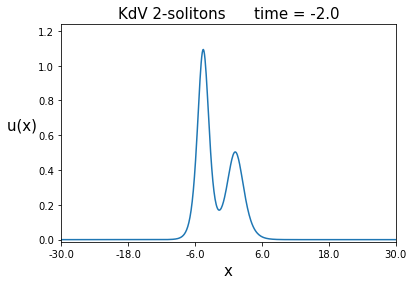

In [8]:
t = -2.0
two_solitons.plot(t);

アニメーションを作成
※実行環境が整っている場合

CompletedProcess(args='convert -layers optimize -loop 0 -delay 10 2soliton_animation/*.png ./2_soliton.gif', returncode=0)

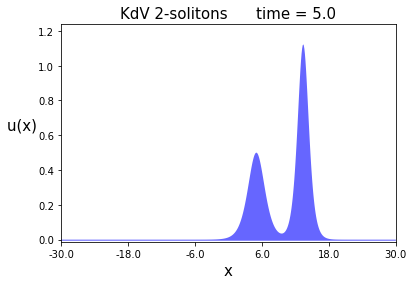

In [9]:
make_animation_frames(two_solitons, "2soliton_animation", ".", Create_animation=True, time_interval=10, facecolor='b', alpha=0.6)

#### 3-ソリトンの計算例

各ソリトンのパラメータを
$( p_1 = 1.2, \theta_1 = 0.0 )$、
$( p_2 = 2.0, \theta_2 = 5.0 )$、
$( p_3 = 2.5, \theta_3 = -15.0 )$
にセット

In [10]:
three_solitons = KdV_tau(N=3, p=[1.2, 2., 2.5], theta=[0., 5., -15.])

$x$の範囲を-30から40に指定し、0.1間隔とします

In [11]:
three_solitons.set_X_range(-30,40,DeltaX=0.01)

時間$t$に依存しない計算を予め計算しておき、無駄を省きます

In [12]:
three_solitons.setup()

3-ソリトン解
	  p_1 = 1.200, p_2 = 2.000, p_3 = 2.500, 
	  theta_1 = 0.000, theta_2 = 5.000, theta_3 = -15.000, 


$t$の値を$-3.0$から$6.0$まで$0.1$刻みで計算してみます

In [13]:
%%time
t_start = - 3.0
t_end = 6.0 + 1e-7
Delta_t = 0.1
three_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 182 ms


時刻$t$の時の$u$の概形をプロット

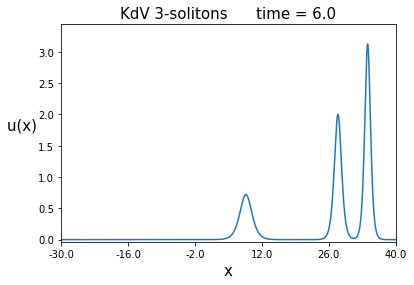

In [14]:
t = 6.0
three_solitons.plot(t);

アニメーションを作成
※実行環境が整っている場合

CompletedProcess(args='convert -layers optimize -loop 0 -delay 10 3soliton_animation/*.png ./3_soliton.gif', returncode=0)

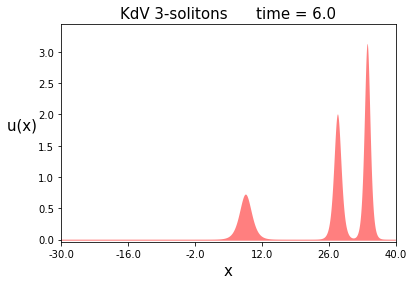

In [15]:
make_animation_frames(three_solitons, "3soliton_animation", ".", Create_animation=True, time_interval=10, facecolor='r', alpha=0.5)

#### 4-ソリトンの計算例

各ソリトンのパラメータを
$( p_1 = 1.2, \theta_1 = 0.0 )$、
$( p_2 = 1.3, \theta_2 = 0.0 )$、
$( p_3 = 2.4, \theta_3 = -10.0 )$、
$( p_4 = 2.5, \theta_3 = -10.0 )$
にセット

In [16]:
four_solitons = KdV_tau(N=4, p=[1.2, 1.3, 2.4, 2.5], theta=[0., 0., -10., -10.])

$x$の範囲を-30から40に指定し、0.1間隔とします

In [17]:
four_solitons.set_X_range(-30,40,DeltaX=0.1)

時間$t$に依存しない計算を予め計算しておき、無駄を省きます

In [18]:
four_solitons.setup()

4-ソリトン解
	  p_1 = 1.200, p_2 = 1.300, p_3 = 2.400, p_4 = 2.500, 
	  theta_1 = 0.000, theta_2 = 0.000, theta_3 = -10.000, theta_4 = -10.000, 


$t$の値を$-3.0$から$5.0$まで$0.1$刻みで計算してみます

In [19]:
%%time
t_start = - 3.0
t_end = 5.0 + 1e-7
Delta_t = 0.1
four_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 50.2 ms


時刻$t$の時の$u$の概形をプロット

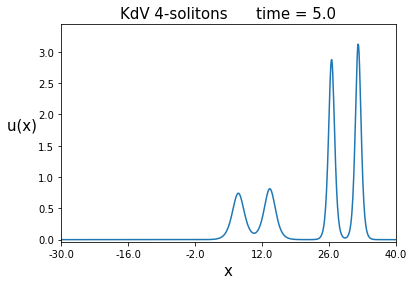

In [20]:
t = 5.0
four_solitons.plot(t);

アニメーションを作成
※実行環境が整っている場合

CompletedProcess(args='convert -layers optimize -loop 0 -delay 10 4soliton_animation/*.png ./4_soliton.gif', returncode=0)

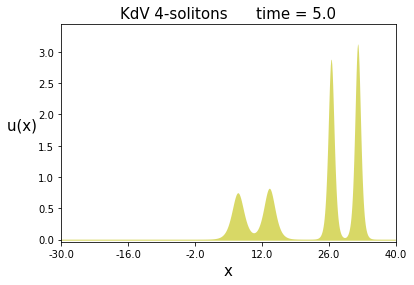

In [21]:
make_animation_frames(four_solitons, "4soliton_animation", ".", Create_animation=True, time_interval=10, facecolor='y', alpha=0.6)

#### 5-ソリトンの計算例

各ソリトンのパラメータを
$( p_1 = 0.7, \theta_1 = 10.0 )$、
$( p_2 = 1.3, \theta_2 = 10.0 )$、
$( p_3 = 1.8, \theta_3 = 5.0 )$、
$( p_4 = 2.2, \theta_4 = 0.0 )$、
$( p_5 = 2.5, \theta_5 = -5.0 )$
にセット

In [22]:
five_solitons = KdV_tau(N=5, p=[0.7, 1.3, 1.8, 2.2, 2.5], theta=[10., 10., 5., 0., -5.])

$x$の範囲を-30から70に指定し、0.1間隔とします

In [23]:
five_solitons.set_X_range(-30,70,DeltaX=0.1)

時間$t$に依存しない計算を予め計算しておき、無駄を省きます

In [24]:
five_solitons.setup()

5-ソリトン解
	  p_1 = 0.700, p_2 = 1.300, p_3 = 1.800, p_4 = 2.200, p_5 = 2.500, 
	  theta_1 = 10.000, theta_2 = 10.000, theta_3 = 5.000, theta_4 = 0.000, theta_5 = -5.000, 


$t$の値を$-5.0$から$10.0$まで$0.1$刻みで計算してみます

In [25]:
%%time
t_start = - 5.0
t_end = 10.0 + 1e-7
Delta_t = 0.1
five_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 168 ms


時刻$t$の時の$u$の概形をプロット

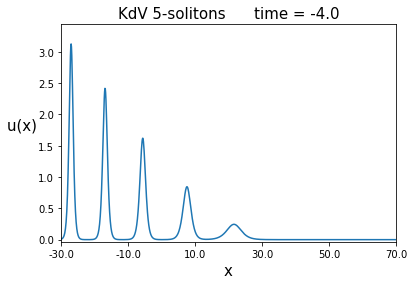

In [26]:
t = -4.0
five_solitons.plot(t);

アニメーションを作成
※実行環境が整っている場合<br>
時間範囲指定もできます

CompletedProcess(args='convert -layers optimize -loop 0 -delay 10 5soliton_animation/*.png ./5_soliton.gif', returncode=0)

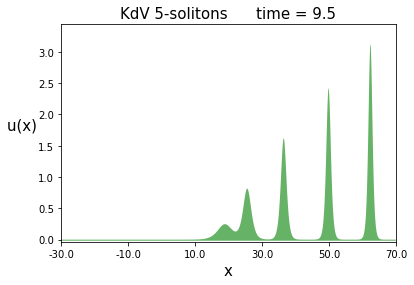

In [27]:
make_animation_frames(five_solitons, "5soliton_animation", ".", Create_animation=True, time_interval=10,
                      t_start=-3.0, t_end=9.5, facecolor='g', alpha=0.6)

一応保存機能もあります

In [28]:
five_solitons.save("./5solition.kdv")

もちろん読み込み機能も

In [29]:
five_solitons.load("./5solition.kdv")

以上、簡単に5-ソリトン解の表示を見てきました。<br>

後は好きなパラメータでいろいろプロットしてみてください。

#### おまけ

In [30]:
fifteen_solitons = KdV_tau(N=15)
fifteen_solitons.set_X_range(-30,30,DeltaX=0.2)
fifteen_solitons.setup()

15-ソリトン解
	  p_1 = 0.271, p_2 = 1.762, p_3 = 2.554, p_4 = 2.398, p_5 = 1.349, p_6 = 0.325, p_7 = 1.434, p_8 = 1.733, p_9 = 2.239, p_10 = 0.043, p_11 = 0.279, p_12 = 2.013, p_13 = 1.960, p_14 = 2.578, p_15 = 0.976, 
	  theta_1 = 0.000, theta_2 = 0.000, theta_3 = 0.000, theta_4 = 0.000, theta_5 = 0.000, theta_6 = 0.000, theta_7 = 0.000, theta_8 = 0.000, theta_9 = 0.000, theta_10 = 0.000, theta_11 = 0.000, theta_12 = 0.000, theta_13 = 0.000, theta_14 = 0.000, theta_15 = 0.000, 


In [31]:
%%time
t_start = - 5.0
t_end = 5.0 + 1e-7
Delta_t = 0.2
fifteen_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

CPU times: user 24.3 s, sys: 23.3 s, total: 47.6 s
Wall time: 47.6 s


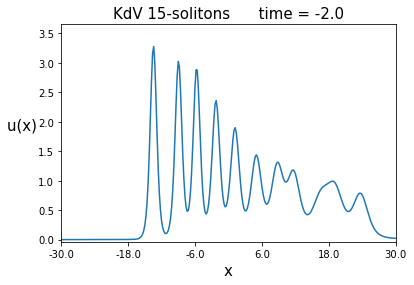

In [32]:
fifteen_solitons.plot(t=-2.0)

## 2. 保存量を計算してみる

※絵的にはあまり面白くないです

#### 復習

* $ \displaystyle Q_1 = \int^{\infty}_{-\infty} dx\; u(x,t)$

* $ \displaystyle Q_2 = \int^{\infty}_{-\infty} dx\; u(x,t)^2$

* $ \displaystyle Q_3 = \int^{\infty}_{-\infty} dx\; \left( u(x,t)^3 - \tfrac{1}{2} u_x(x,t)^2 \right)$

* $ \displaystyle Q_4 = \int^{\infty}_{-\infty} dx\; \left( u(x,t)^4 - 2u(x,t)u_x(x,t)^2 + \tfrac{1}{5} u_{xx}(x,t)^2 \right)$

In [33]:
# 微分を計算
def _first_derivative(f, Delta):
    return ( np.roll(f, shift=-1) - np.roll(f, shift=1) ) / ( 2. * Delta )
def _second_derivative(f, Delta):
    return ( np.roll(f, shift=-1) + np.roll(f, shift=1) - 2. * f ) / ( Delta ** 2. )

In [34]:
def compute_four_KdV_conserved_quantities(KdV_solitons):
    x_seq = KdV_solitons.x
    time_seq = KdV_solitons._time
    Delta = KdV_solitons.DeltaX
    
    charges = []
    # xの3階微分が必要なので、端は切り落とす
    truncation = np.arange(3,len(x_seq)-3)
    for t in time_seq:
        u = KdV_solitons._u_evolve[t]
        u_x = _first_derivative(u, Delta=Delta)[truncation]
        u_xx = _second_derivative(u, Delta=Delta)[truncation]
        u = u[truncation]
        
        q1 = np.sum(u)
        q2 = np.sum(u**2)
        q3 = np.sum(u**3) - 0.5 * np.sum(u_x**2)
        q4 = np.sum(u**4) - 2.0 * np.sum(u*u_x**2) + 0.2 * np.sum(u_xx**2)

        charges.append([q1,q2,q3,q4])
        
    charges = np.array(charges) * Delta
    
    plt.title("KdV charges")
    plt.xlabel("time")
    for i,c in enumerate(charges.T):
        plt.plot(KdV_solitons._time, c, label="$Q_{0}$".format(i+1))
    plt.legend()
    
    return charges

前節で計算した結果から保存量を計算しましょう。ここでは積分を、特に工夫をせずに、単純な和で計算しています。

また時間変化をプロットしてみましょう。

2-ソリトン解

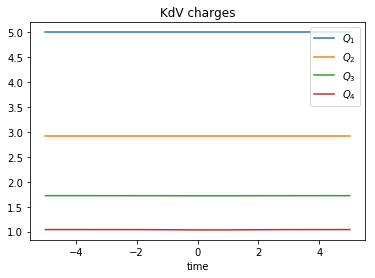

In [35]:
KdV_charges = compute_four_KdV_conserved_quantities(two_solitons)

3-ソリトン解

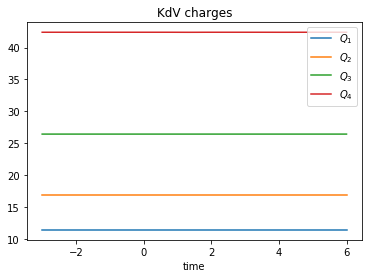

In [36]:
KdV_charges = compute_four_KdV_conserved_quantities(three_solitons)

$Q_4$が真っ直ぐでないのは、数値誤差が効いているためです。<br>
参考までに$\Delta x=0.01$として計算したものが以下です：

In [37]:
three_solitons.set_X_range(-30,40,DeltaX=0.01)
three_solitons.setup()
t_start = - 3.0
t_end = 6.0 + 1e-7
Delta_t = 0.1
three_solitons.compute_u(list(np.arange(t_start,t_end,Delta_t)))

3-ソリトン解
	  p_1 = 1.200, p_2 = 2.000, p_3 = 2.500, 
	  theta_1 = 0.000, theta_2 = 5.000, theta_3 = -15.000, 


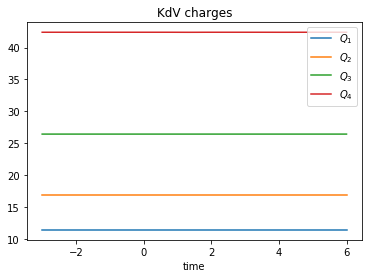

In [38]:
KdV_charges = compute_four_KdV_conserved_quantities(three_solitons)

予想通り、ずれが肉眼では見えないほど小さくなっていますね。

4-ソリトン解

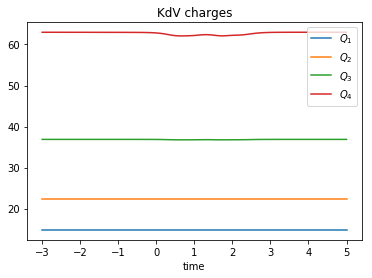

In [39]:
KdV_charges = compute_four_KdV_conserved_quantities(four_solitons)

5-ソリトン解

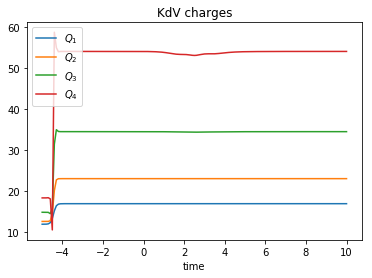

In [40]:
KdV_charges = compute_four_KdV_conserved_quantities(five_solitons)

※5-ソリトンの時刻$t=-4$直前では、ソリトンがはみ出してるため、上手くいっていない事に注意

## 3. 2-ソリトン解の表式を計算させてみる

最後に、2-ソリトン解を$\tau$関数から計算させてみましょう。

In [41]:
import sympy as sym
from sympy import exp, log
# インラインで綺麗に表示
from sympy import init_printing
init_printing()

準備

In [42]:
x = sym.symbols("x")
t = sym.symbols("t")
N = 2
for i in range(1,N+1):
    exec("p{0} = sym.symbols('p_{0}')".format(i))
    exec("th{0} = sym.symbols('theta_{0}')".format(i))
    exec("eta{0} = p{0} * x - p{0} ** 3 * t - th{0}".format(i))
A = (p1 - p2)**2 / (p1 + p2)**2

2-ソリトン解の$\tau$関数

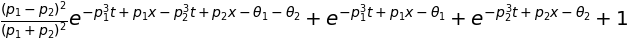

In [43]:
tau = 1 + exp(eta1) + exp(eta2) + A * exp(eta1+eta2)
tau

$u(x,t)$を計算

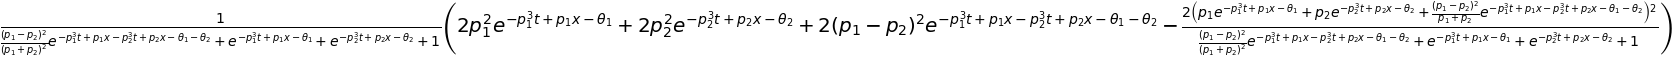

In [44]:
u = 2*sym.diff(log(tau), x, 2)
u

パラメータを数値としてセット

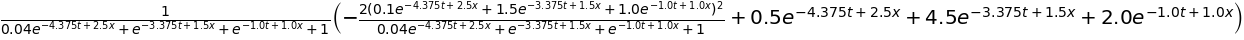

In [45]:
u_set_params = u.subs([(p1, 1.), (p2, 1.5), (th1, 0.), (th2, 0.)])
u_set_params

時間を指定して概形をプロット

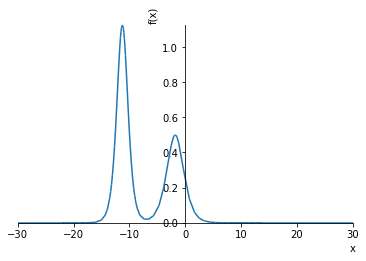

In [46]:
u_set_t = u_set_params.subs([(t,-5)])
sym.plot(u_set_t, (x,-30,30));

まあ同じ事をしているので当たり前ですが、2-ソリトン解ですね。